# Pancancer oncRNA: Preprocess TCGA Data
Preprocess all the TCGA data for downstream pancancer locus analysis


In [1]:
import pandas as pd
from scipy.signal import find_peaks, peak_widths
import os
import json as js
import pymongo
import matplotlib.pyplot as plt
import numpy as np
import os

## Preprocess Data

### Dust
Before converting the TCGA bam files to bed files, we first implement a low-complexity sequence filter to eliminate potential artifact reads. 

Command (smRNA env): <br>
`python3 scripts/dust_filter.py &> log/dust_filter.out`

### Bamtobed
Next step is to convert all the bam files to bed files.

Command (smRNA env): <br>
`ls /rumi/shams/jwang/TCGA_oncRNA/data/*.dust.bam | parallel -j 30 bash scripts/bamtobed.sh {} &> log/bamtobed.out`

### Filter TCGA: 


Command to run in TCGA_oncRNA directory in smRNA env: <br>
`python3 scripts/filter_TCGA.py &> log/filter_TCGA.out`

Moved all TCGA files into another subdirectory in `data/` called `TCGA/`

### Find all unique loci

Parallelized script version: <br>
Command in proj directory smRNA env <br>
`python3 scripts/find_unique_loci.py &> log/find_unique_loci.out`

### Merge all loci

Command <br>
`cat data/tcga_all_unique_loci.bed | sort -k1,1 -k2,2n | mergeBed -s -c 6 -o distinct -i stdin | awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3":"$4  "\t.\t" $4 > "data/tcga_merged_smRNAs_loci.bed"}'`

## Split Loci
Since some of the locus features are too long, we need to implement a method to split the loci based on peaks. Here we have **310372** loci to split.

In [2]:
all_loci = pd.read_csv("data/tcga_merged_smRNAs_loci.bed", header=None, sep="\t")
print(all_loci.shape)
all_loci.head()

(74710201, 6)


,0,1,2,3,4,5
0,chr1,155,171,chr1:155-171:+,.,+
1,chr1,568,585,chr1:568-585:-,.,-
2,chr1,660,678,chr1:660-678:+,.,+
3,chr1,730,747,chr1:730-747:-,.,-
4,chr1,858,873,chr1:858-873:+,.,+


In [3]:
all_loci["length"] = all_loci[2] - all_loci[1]
loci_to_split = all_loci[all_loci["length"] > 200]
print(loci_to_split.shape)
loci_to_split.head()

(310372, 7)


,0,1,2,3,4,5,length
46,chr1,9983,10238,chr1:9983-10238:-,.,-,255
52,chr1,10255,10619,chr1:10255-10619:-,.,-,364
143,chr1,13287,13505,chr1:13287-13505:-,.,-,218
178,chr1,14402,15124,chr1:14402-15124:-,.,-,722
200,chr1,15363,15568,chr1:15363-15568:-,.,-,205


Text(0, 0.5, 'Number of loci')

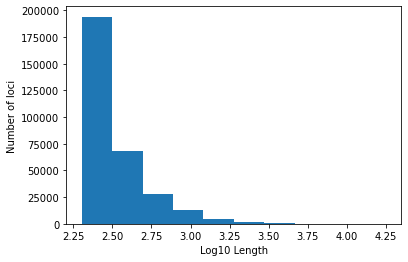

In [4]:
plt.hist(np.log10(loci_to_split["length"]))
plt.xlabel("Log10 Length")
plt.ylabel("Number of loci")

In [5]:
loci_to_split.iloc[:, :-1].to_csv("data/tcga_merged_loci_to_split.bed", header=None, index=None, sep="\t")

### Intersect Loci to Split

First we intersect all the TCGA samples with the locus features that are too long to generate a sense of coverage across the loci for splitting purposes. <br>
Command: <br>
`ls /rumi/shams/jwang/TCGA_oncRNA/data/TCGA/*.filter.bed | parallel -j 20 bash scripts/intersect_TCGA_split_loci.sh {} &> log/intersect_TCGA_split_loci.out`

### Generate Genomecov
Next we run the below script to generate genomecoverage for each oversized locus for each TCGA sample to then run peak calling. <br>
Command: <br>
`python3 scripts/genomecov.py &> log/genomecov_python.out`

### Merge genomecov
Next we merge all the TCGA genomecov results into a single dictionary for splitting.

Command: <br>
`python3 scripts/merge_genomecov.py &> log/merge_genomecov_python.out`

### Peak Calling and Loci Splitting

In [6]:
with open("data/merged_loci_to_split_coverage.json","r") as f:   
    loci_coverage_dict = js.load(f)

In [7]:
len(loci_coverage_dict)

310372

In [8]:
new_loci_list = []
for locus, cov in loci_coverage_dict.items():
    splits = locus.split(":")
    ref = splits[0]
    start = int(splits[1].split("-")[0])
    end = int(splits[1].split("-")[1])
    strand = splits[2]
    coverage = np.array(loci_coverage_dict[locus])
    coord = np.arange(start, end)
    peaks, _ = find_peaks(coverage, height=10, rel_height=0.5, width=[15, 200], distance=20)
    results = peak_widths(coverage, peaks, rel_height=0.5)  
    
    #peak_widths returns 4 arrays in order: peak widths, peak heights, peak start, peak end.
    for new_start_index, new_end_index in zip(results[2], results[3]):
        new_start_index, new_end_index = int(new_start_index), int(new_end_index) #These are the new indices, based on peaks
        new_start = coord[new_start_index]
        new_end = coord[new_end_index]

        if new_end - new_start + 9 < 200: #Add additional nt buffer if loci length is not too large.
            new_start -= 4
            new_end += 5 
        new_locus = f"{ref}:{new_start}-{new_end}:{strand}"
        new_loci_list.append(new_locus)

In [9]:
len(new_loci_list)

1637234

In [10]:
loci_list = all_loci[all_loci["length"] <= 200][3].tolist()
loci_list.extend(new_loci_list)
len(loci_list)

76037063

In [11]:
with open("data/tcga_split_smRNAs_loci.bed", "wt") as out:   
    for locus in loci_list:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")

In [12]:
%%bash
cat data/tcga_split_smRNAs_loci.bed | sort -k1,1 -k2,2n | mergeBed -s -c 6 -o distinct -i stdin | \
awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3":"$4  "\t." "\t" $4  > "data/tcga_smRNAs_loci_map.bed"}' 

In [13]:
loci_map = pd.read_csv("data/tcga_smRNAs_loci_map.bed", header=None, sep="\t")[3]
len(loci_map)

75944600

Our final feature map has 75944600 unqiue loci

## exRNA Filter
Here we filter out all the loci that are also seen in non-cancerous samples from the exRNA Atlas and other publically available non-cancerous exosomal smRNAseq datasets. 


Command: <br>
`ls /rumi/shams/jwang/exRNA_atlas/data/bedfiles/*.srt.filter.bed | parallel -j 30 bash scripts/intersect_exRNA_atlas_loci.sh {} &> log/intersect_exRNA_atlas_loci.out` <br>


The main command in the script is: <br>
`intersectBed -s -u -a data/tcga_smRNAs_loci_map.bed-b $1 > data/exRNA/$out` <br>
The `-u` option reports a locus in `-a` **once** when there is at least one overlap with `-b`

In [14]:
exRNA_intersect_files = [f for f in os.scandir("data/exRNA") if os.stat(f).st_size != 0 and f.name.endswith(".bed")] #Exclude empty no hit samples.
len(exRNA_intersect_files)

1383

In [15]:
exRNA_loci_hits = {}
for file in exRNA_intersect_files:
    df = pd.read_csv(file, sep="\t", header=None)
    for locus in df[3]:
        if locus in exRNA_loci_hits:
            exRNA_loci_hits[locus] += 1
        else:
            exRNA_loci_hits[locus] = 1
len(exRNA_loci_hits) #Represents number of loci in our loci feature map that had at least one overlap with a sample in the exRNA atlas

35576447

In [16]:
exRNA_loci_hits_df = pd.DataFrame.from_dict(exRNA_loci_hits, orient="index", columns=["counts"])
exRNA_loci_hits_df = exRNA_loci_hits_df.reset_index(drop=False).rename(columns={"index":"loci"})
exRNA_loci_hits_df.head()

,loci,counts
0,chr1:16835-16862:-,216
1,chr1:17264-17294:-,3
2,chr1:102826-102850:+,144
3,chr1:137320-137376:+,62
4,chr1:187357-187409:-,227


In [17]:
total_loci_num = 75944600
exRNA_filter_results = {"threshold":[], "count":[]}
for th in range(1, 50):
    exRNA_filter_results["threshold"].append(th)
    exRNA_filter_results["count"].append(total_loci_num - np.sum(exRNA_loci_hits_df["counts"] >= th)) #Number of total loci minus number of loci eliminated (loci that intersected with or more than th samples) given a threshold TH
exRNA_filter_results = pd.DataFrame(exRNA_filter_results)

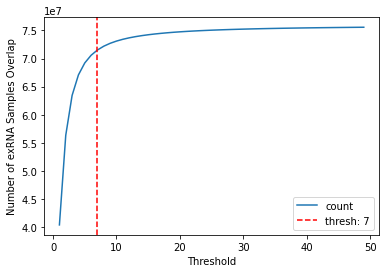

In [18]:
plt.plot('threshold', 'count', data=exRNA_filter_results)
plt.xlabel("Threshold")
plt.ylabel("Number of exRNA Samples Overlap")
ax = plt.gca()
cutoff=7
ax.axvline(cutoff, color = "r", ls="--", label=f"thresh: {cutoff}")
plt.legend()
plt.savefig("figures/exRNA_atlas_samples_filter_thresh.pdf")

In [19]:
to_remove = set(exRNA_loci_hits_df[exRNA_loci_hits_df["counts"] >= 7]["loci"])
len(to_remove)

4426820

In [20]:
exRNA_filtered_loci = []
for locus in loci_map:
    if locus not in to_remove:
        exRNA_filtered_loci.append(locus)
len(exRNA_filtered_loci), len(loci_map)

(71517780, 75944600)

In [21]:
with open("data/tcga_smRNAs_loci_map_exRNA_filtered.bed", "w") as out: 
    for locus in exRNA_filtered_loci:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")

4426820 loci (out of 75944600) were removed at the exRNA filter step. This corresponds to about **5.8%** of our total loci (post-splitting).

## Intersect Loci
Here we intersect our filtered TCGA samples with our finalized loci feature map for downstream analysis.

Command: <br>
`ls /rumi/shams/jwang/TCGA_oncRNA/data/TCGA/*.filter.bed | parallel -j 10 bash scripts/intersect_TCGA_loci.sh {} &> log/intersect_TCGA_loci.out`

## Insert Data into mongoDB 

Command:<br>
`python3 scripts/insert_TCGA.py &> log/insert_mongo.out` 

## Create Index

In [22]:
myclient = pymongo.MongoClient(port=27027)
mydb = myclient["TCGA_loci"]
rnacol = mydb["smRNAs"]

In [23]:
rnacol.create_index([("locus", pymongo.ASCENDING)])

'locus_1'

In [24]:
pipeline = [
{"$group": {"_id": {"locus" :"$locus"},
                        "raw_total": {"$sum": "$raw_total"},
                        "samples": {"$push": "$samples"}}},
            {"$out": "smRNAagg"}]

In [26]:
rnacol.aggregate(pipeline, allowDiskUse=True)

## Done